In [1]:
import cv2
import os
import pathlib
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import f1_score, recall_score, precision_score
from tensorflow.keras.applications import VGG16
from scipy.linalg import sqrtm
from sklearn.metrics.pairwise import polynomial_kernel

In [2]:
class ReadDataset:
    def __init__(self, datasetpath, labels, image_shape):
        self.datasetpath = datasetpath
        self.labels = labels
        self.image_shape = image_shape
    def returListImages(self,):
        self.images = []
        for label in self.labels:
            self.images.append(list(pathlib.Path(os.path.join(self.datasetpath,
                                                              label)).glob('*.*')))
    def readImages(self,):
        self.returListImages()
        self.finalImages = []
        labels = []
        for label in range(len(self.labels)):
            for img in self.images[label]:
                img = cv2.imread(str(img), cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img , self.image_shape[:2])
                img  = img/255
                img = np.expand_dims(img, axis=-1)  # Add channel dimension to get shape (64, 64, 1)
                self.finalImages.append(img)
                labels.append(label)
        images = np.array(self.finalImages)
        labels = np.array(labels)
        return images, labels

In [3]:
readDatasetObject = ReadDataset('train',
                               ['NORMAL', 'PNEUMONIA'],
                               (64, 64))
images, labels = readDatasetObject.readImages()
images.shape, labels.shape

((1000, 64, 64, 1), (1000,))

In [4]:
class CVAE(Model):
    def __init__(self, latent_dim, num_classes, input_shape):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes

        # Encoder network
        self.encoder_inputs = layers.Input(shape=(input_shape[0], input_shape[1], 1))
        self.label_inputs = layers.Input(shape=(num_classes,))
        
        x = layers.Conv2D(32, (3, 3), activation='relu', strides=2, padding='same')(self.encoder_inputs)
        x = layers.Conv2D(64, (3, 3), activation='relu', strides=2, padding='same')(x)
        x = layers.Flatten()(x)
        x = layers.Concatenate()([x, self.label_inputs])
        x = layers.Dense(128, activation='relu')(x)
        
        self.z_mean = layers.Dense(latent_dim)(x)
        self.z_log_var = layers.Dense(latent_dim)(x)

        # Decoder network
        self.decoder_inputs = layers.Input(shape=(latent_dim,))
        self.decoder_labels = layers.Input(shape=(num_classes,))
        x = layers.Concatenate()([self.decoder_inputs, self.decoder_labels])
        x = layers.Dense(16 * 16 * 64, activation='relu')(x)
        x = layers.Reshape((16, 16, 64))(x)
        x = layers.Conv2DTranspose(64, (3, 3), activation='relu', strides=2, padding='same')(x)
        x = layers.Conv2DTranspose(32, (3, 3), activation='relu', strides=2, padding='same')(x)
        decoder_outputs = layers.Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(x)

        self.encoder = Model([self.encoder_inputs, self.label_inputs], [self.z_mean, self.z_log_var])
        self.decoder = Model([self.decoder_inputs, self.decoder_labels], decoder_outputs)

    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(self.latent_dim,))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x, labels):
        z_mean, z_log_var = self.encoder([x, labels])
        eps = tf.random.normal(shape=z_mean.shape)
        z = z_mean + tf.exp(0.5 * z_log_var) * eps
        return z, z_mean, z_log_var

    def decode(self, z, labels, apply_sigmoid=False):
        logits = self.decoder([z, labels])
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

    def call(self, inputs):
        x, labels = inputs
        z, z_mean, z_log_var = self.encode(x, labels)
        reconstructed = self.decode(z, labels)
        return reconstructed, z_mean, z_log_var

# Example usage
latent_dim = 16
num_classes = 2
input_shape = (64, 64)

cvae = CVAE(latent_dim, num_classes, input_shape)

In [5]:
# Convert labels to Tensors
def one_hot_encode_labels(labels, num_classes):
    return tf.convert_to_tensor(tf.one_hot(labels, num_classes))

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

# Loss function
def compute_loss(model, x, labels):
    z, z_mean, z_log_var = model.encode(x, labels)
    x_reconstructed = model.decode(z, labels)
    reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.keras.losses.binary_crossentropy(x, x_reconstructed), axis=(1, 2)))
    kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1))
    return reconstruction_loss + kl_loss

# Training step
@tf.function
def train_step(model, x, labels, optimizer):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x, labels)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

# Convert labels to one-hot encoding
def one_hot_encode_labels(labels, num_classes):
    return tf.one_hot(labels, num_classes)

# Prepare the dataset
images = np.array(images).astype('float32')
labels = one_hot_encode_labels(labels, num_classes)

# Create a TensorFlow dataset
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices((images, labels)).shuffle(10000).batch(batch_size)

# Optimizer
optimizer = Adam(learning_rate=1e-3)

# Training loop
epochs = 100
for epoch in range(epochs):
    for x_batch, labels_batch in dataset:
        x_batch = tf.convert_to_tensor(x_batch)
        labels_batch = tf.convert_to_tensor(labels_batch)
        train_step(cvae, x_batch, labels_batch, optimizer)
    print(f'Epoch {epoch + 1} completed')




Epoch 1 completed
Epoch 2 completed
Epoch 3 completed
Epoch 4 completed
Epoch 5 completed
Epoch 6 completed
Epoch 7 completed
Epoch 8 completed
Epoch 9 completed
Epoch 10 completed
Epoch 11 completed
Epoch 12 completed
Epoch 13 completed
Epoch 14 completed
Epoch 15 completed
Epoch 16 completed
Epoch 17 completed
Epoch 18 completed
Epoch 19 completed
Epoch 20 completed
Epoch 21 completed
Epoch 22 completed
Epoch 23 completed
Epoch 24 completed
Epoch 25 completed
Epoch 26 completed
Epoch 27 completed
Epoch 28 completed
Epoch 29 completed
Epoch 30 completed
Epoch 31 completed
Epoch 32 completed
Epoch 33 completed
Epoch 34 completed
Epoch 35 completed
Epoch 36 completed
Epoch 37 completed
Epoch 38 completed
Epoch 39 completed
Epoch 40 completed
Epoch 41 completed
Epoch 42 completed
Epoch 43 completed
Epoch 44 completed
Epoch 45 completed
Epoch 46 completed
Epoch 47 completed
Epoch 48 completed
Epoch 49 completed
Epoch 50 completed
Epoch 51 completed
Epoch 52 completed
Epoch 53 completed
Ep

In [7]:
def calculate_fid(real_images, generated_images):
    # Load pre-trained VGG16 model
    vgg_model = VGG16(include_top=False, pooling='avg', input_shape=(64, 64, 3))
    
    # Get the activations from the model for real and generated images
    act_real = vgg_model.predict(real_images)
    act_gen = vgg_model.predict(generated_images)

    # Calculate the mean and covariance of the activations
    mu_real, sigma_real = np.mean(act_real, axis=0), np.cov(act_real, rowvar=False)
    mu_gen, sigma_gen = np.mean(act_gen, axis=0), np.cov(act_gen, rowvar=False)

    # Calculate FID score
    ssdiff = np.sum((mu_real - mu_gen)**2.0)
    covmean = sqrtm(sigma_real.dot(sigma_gen))
    
    # Numerical error can occur in sqrtm, so check if the result is complex
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = ssdiff + np.trace(sigma_real + sigma_gen - 2.0 * covmean)
    return fid
def calculate_kid(real_images, generated_images):
    # Load pre-trained VGG16 model
    vgg_model = VGG16(include_top=False, pooling='avg', input_shape=(64, 64, 3))
    
    # Get the activations from the model for real and generated images
    act_real = vgg_model.predict(real_images)
    act_gen = vgg_model.predict(generated_images)
    
    # Compute polynomial kernels
    kernel_real = polynomial_kernel(act_real)
    kernel_gen = polynomial_kernel(act_gen)
    kernel_cross = polynomial_kernel(act_real, act_gen)
    
    m = len(real_images)
    n = len(generated_images)
    
    # Calculate KID score
    kid = (np.sum(kernel_real) / (m * m)) + (np.sum(kernel_gen) / (n * n)) - (2 * np.sum(kernel_cross) / (m * n))
    return kid
def convert_grayscale_to_rgb(images):
    # Convert numpy array to TensorFlow tensor
    images_tensor = tf.convert_to_tensor(images)
    # Convert grayscale images to RGB
    return tf.image.grayscale_to_rgb(images_tensor)

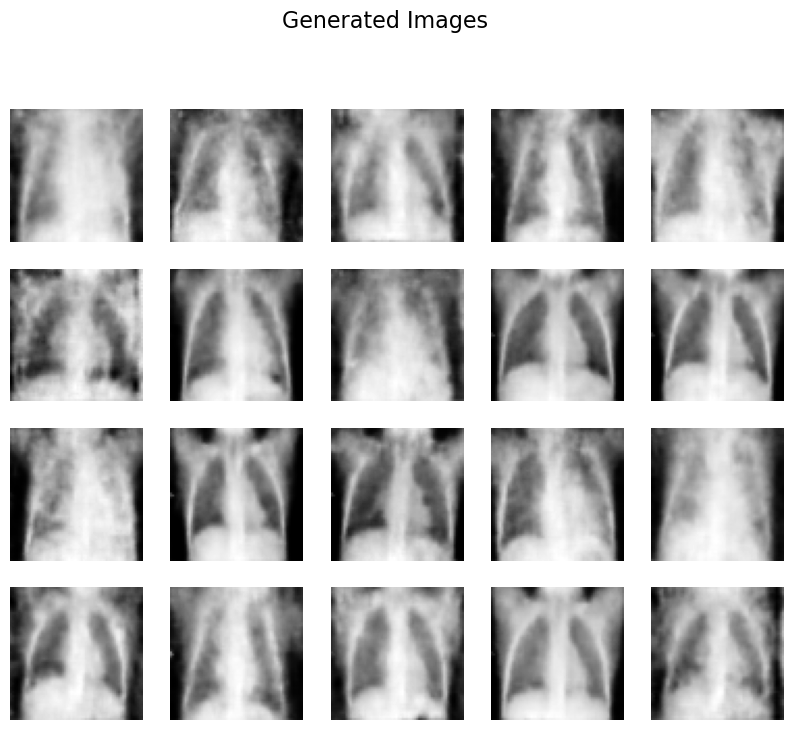

32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 240ms/step
106/106 ━━━━━━━━━━━━━━━━━━━━ 26s 245ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 248ms/step
106/106 ━━━━━━━━━━━━━━━━━━━━ 26s 241ms/step
FID Score: 25.34262613654551
KID Score: 0.18154998297489922


In [8]:
def plot_images(images, num_images=20, image_size=(64, 64), title="Generated Images"):
    # Calculate the grid size
    grid_size = int(np.ceil(np.sqrt(num_images)))
    
    # Create the plot
    plt.figure(figsize=(grid_size * 2, grid_size * 2))
    
    for i in range(num_images):
        ax = plt.subplot(grid_size, grid_size, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.axis('off')
    
    if title:
        plt.suptitle(title, fontsize=16)
    
    plt.show()

# Generate synthetic images
latent_vectors = np.random.normal(size=(3389, latent_dim))  # Generate random latent vectors
newlabels = tf.keras.utils.to_categorical(np.random.choice([0, 1], size = (3389, )), num_classes = 2)


# Generate synthetic images using the decoder from the CVAE model
generated_images = cvae.decode(latent_vectors, newlabels, apply_sigmoid=True)

plot_images(generated_images)

# Convert grayscale images to RGB
real_images_rgb = convert_grayscale_to_rgb(images)
generated_images_rgb = convert_grayscale_to_rgb(generated_images)

# Calculate FID and KID scores
fid_score = calculate_fid(real_images_rgb, generated_images_rgb)
kid_score = calculate_kid(real_images_rgb, generated_images_rgb)

print(f'FID Score: {fid_score}')
print(f'KID Score: {kid_score}')





In [9]:
# Convert TensorFlow tensors to NumPy arrays if necessary
generated_images = generated_images.numpy()
basemodel = tf.keras.applications.VGG16(weights = None, input_shape = (64, 64, 1),
                                        pooling = 'max', include_top = False)
x = layers.Dropout(0.4)(basemodel.output)
x = layers.Dense(128,)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(negative_slope = 0.2)(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(32,)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(negative_slope = 0.2)(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(1, activation = 'sigmoid')(x)
m = tf.keras.models.Model(inputs = basemodel.input, outputs = x)
m.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00002))
m.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 64, 64, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 64, 64, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d                 │ (None, 512)                 │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │              

 Total params: 14,784,001 (56.40 MB)

 Trainable params: 14,783,681 (56.40 MB)

 Non-trainable params: 320 (1.25 KB)

In [10]:
history = m.fit(generated_images, np.argmax(newlabels, axis = 1),
                epochs = 60, batch_size = 64,
                validation_split = 0.2,
                callbacks = [tf.keras.callbacks.EarlyStopping(patience = 2, monitor = 'val_loss', mode = 'min',
                                                              restore_best_weights = True)])

Epoch 1/60
43/43 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - loss: 0.7549 - val_loss: 0.6931
Epoch 2/60
43/43 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - loss: 0.6953 - val_loss: 0.6931
Epoch 3/60
43/43 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - loss: 0.6802 - val_loss: 0.6931
Epoch 4/60
43/43 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - loss: 0.6232 - val_loss: 0.6913
Epoch 5/60
43/43 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - loss: 0.3985 - val_loss: 0.6834
Epoch 6/60
43/43 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - loss: 0.1961 - val_loss: 0.6631
Epoch 7/60
43/43 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - loss: 0.1460 - val_loss: 0.6369
Epoch 8/60
43/43 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - loss: 0.1147 - val_loss: 0.5980
Epoch 9/60
43/43 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - loss: 0.0873 - val_loss: 0.5417
Epoch 10/60
43/43 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - loss: 0.0742 - val_loss: 0.4748
Epoch 11/60
43/43 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - loss: 0.0812 - val_loss: 0.3819
Epoch 12/60
43/43 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - loss: 0.0650 - val_lo

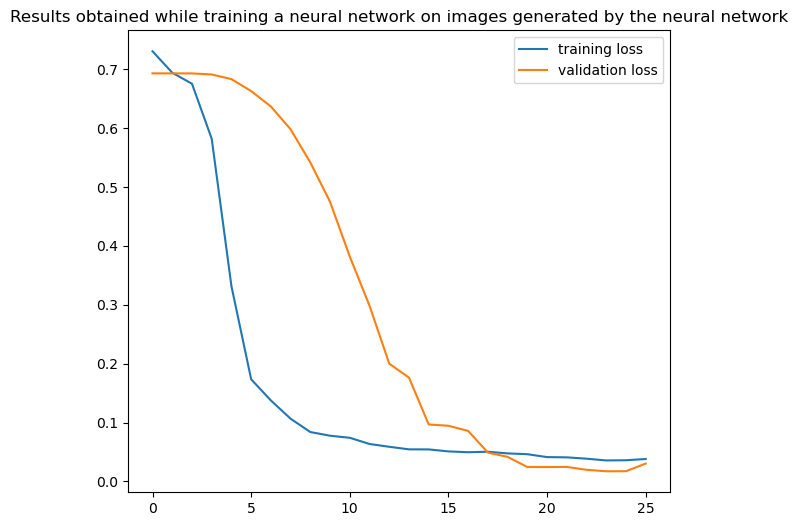

In [11]:
plt.figure(figsize = (7, 6))
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.title('Results obtained while training a neural network on images generated by the neural network')
plt.legend()

In [12]:
labels = np.argmax(labels, axis=1)  # Convert one-hot to binary labels (0 or 1)

In [13]:
images.shape,labels.shape

((1000, 64, 64, 1), (1000,))

In [14]:
m.evaluate(images, labels)

32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 230ms/step - loss: 0.1065


0.15815940499305725

In [15]:
y_pred = tf.squeeze(m.predict(images))
y_pred.shape

32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 242ms/step


TensorShape([1000])

In [16]:
y_pred = y_pred >= 0.5
y_pred = np.array(y_pred, dtype = 'int32')
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [17]:
accuracy_score(y_pred, labels)*100

94.19999999999999

In [18]:
print(classification_report(y_pred, labels))

              precision    recall  f1-score   support

           0       0.98      0.91      0.94       540
           1       0.90      0.98      0.94       460

    accuracy                           0.94      1000
   macro avg       0.94      0.94      0.94      1000
weighted avg       0.95      0.94      0.94      1000



In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_pred, labels)
cm

array([[491,  49],
       [  9, 451]], dtype=int64)

In [20]:
import pandas as pd
cmObject = pd.DataFrame(cm , index = ['NORMAL', 'PNEUMONIA'],
                        columns = ['NORMAL', 'PNEUMONIA'])
cmObject.head()

,NORMAL,PNEUMONIA
NORMAL,491,49
PNEUMONIA,9,451


In [21]:
print('f1_score: {}, recall_score: {}, precision_score: {}'.format(f1_score(y_pred, labels)*100,
                                                                   recall_score(y_pred, labels)*100,
                                                                   precision_score(y_pred, labels)*100))

f1_score: 93.95833333333333, recall_score: 98.04347826086956, precision_score: 90.2


<Axes: >

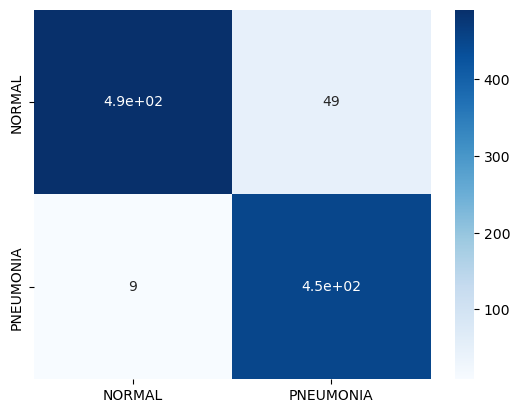

In [22]:
sns.heatmap(cmObject, annot = True, cmap="Blues")